MLB Player Valuation Model

This notebook demonstrates the development of a player valuation model using advanced statistics and machine learning techniques. This type of analysis is directly relevant to MLB front office roles, such as those at the Miami Marlins.

## Objectives
1. Develop a comprehensive player valuation framework
2. Implement Bayesian modeling for player performance prediction
3. Create a salary efficiency metric
4. Build a player comparison system

## 1. Setup and Data Preparation

First, let's import the necessary libraries and prepare our data.

In [1]:
# Install required packages (only needed in Colab)
# Uncomment the following line if running in Colab
!pip install pybaseball pandas numpy matplotlib seaborn scikit-learn statsmodels scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.5 MB/s eta 0:00:00


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import batting_stats, pitching_stats, playerid_lookup
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

In [4]:
print("Libraries imported successfully!")

Libraries imported successfully!


Option 1: Retrieve actual data from MLB APIs (uncomment to use)
batting_2024 = batting_stats(2024)
pitching_2024 = pitching_stats(2024)

In [5]:
# Option 2: For demonstration, we'll create simulated player data
print("Creating simulated player data for 2024 season...")
np.random.seed(42)
n_players = 250

Creating simulated player data for 2024 season...


In [6]:
# Create player names
first_names = ['John', 'Mike', 'David', 'Carlos', 'Jose', 'Aaron', 'Mookie', 'Juan', 'Bryce', 'Freddie',
               'Shohei', 'Fernando', 'Ronald', 'Francisco', 'Pete', 'Vladimir', 'Yordan', 'Gunnar', 'Bobby', 'Corbin']
last_names = ['Smith', 'Johnson', 'Martinez', 'Rodriguez', 'Trout', 'Judge', 'Betts', 'Soto', 'Harper', 'Freeman',
              'Ohtani', 'Tatis', 'Acuña', 'Lindor', 'Alonso', 'Guerrero', 'Alvarez', 'Henderson', 'Witt', 'Burnes']

In [7]:
# Create some realistic player names
real_players = [
    'Aaron Judge', 'Shohei Ohtani', 'Juan Soto', 'Mookie Betts', 'Freddie Freeman',
    'Bryce Harper', 'Vladimir Guerrero Jr.', 'Fernando Tatis Jr.', 'Ronald Acuña Jr.', 'Mike Trout',
    'Yordan Alvarez', 'Francisco Lindor', 'Corbin Burnes', 'Gerrit Cole', 'Bobby Witt Jr.',
    'Gunnar Henderson', 'Corey Seager', 'Jose Ramirez', 'Kyle Tucker', 'Pete Alonso'
]

In [8]:
# Generate random names for the rest
random_players = [f"{np.random.choice(first_names)} {np.random.choice(last_names)}" for _ in range(n_players - len(real_players))]
player_names = real_players + random_players

In [9]:
# Create simulated batting statistics with more realistic relationships
player_data = pd.DataFrame({
    'Name': player_names,
    'Age': np.random.randint(22, 38, n_players),
    'Team': np.random.choice(['NYY', 'BOS', 'LAD', 'HOU', 'ATL', 'CHC', 'NYM', 'SFG', 'STL', 'PHI',
                             'MIA', 'SDP', 'TEX', 'TOR', 'SEA', 'CLE', 'MIN', 'MIL', 'DET', 'KCR'], n_players),
    'Position': np.random.choice(['1B', '2B', '3B', 'SS', 'OF', 'C', 'DH', 'P'], n_players),
})

In [10]:
# Add service time (years in MLB) - this will help create realistic salary relationships
player_data['ServiceTime'] = np.minimum(player_data['Age'] - np.random.randint(20, 25, n_players), 15)
player_data['ServiceTime'] = np.maximum(player_data['ServiceTime'], 0)  # Ensure no negative values

In [11]:
# Create performance metrics with realistic relationships to age and service time
# Base WAR - peaks around age 27-29
player_data['WAR_base'] = -0.005 * (player_data['Age'] - 28)**2 + 3 + np.random.normal(0, 1, n_players)
player_data['WAR_base'] = np.maximum(player_data['WAR_base'], 0)  # No negative base WAR

In [12]:
# Add experience bonus for players with 3-8 years of service time
player_data['WAR'] = player_data['WAR_base'] + 0.2 * (player_data['ServiceTime'] > 3) * (player_data['ServiceTime'] < 8)
player_data['WAR'] = np.maximum(player_data['WAR'], 0)  # Ensure WAR is non-negative

In [13]:
# Games and Plate Appearances (related to WAR)
player_data['G'] = np.random.randint(30, 162, n_players)
player_data['PA'] = player_data['G'] * np.random.randint(2, 5, n_players)

In [14]:
# Create hitting stats with realistic correlations
# Higher WAR players tend to have better stats
player_data['AVG'] = 0.250 + 0.02 * player_data['WAR'] + np.random.normal(0, 0.02, n_players)
player_data['OBP'] = player_data['AVG'] + 0.070 + 0.01 * player_data['WAR'] + np.random.normal(0, 0.02, n_players)
player_data['SLG'] = player_data['AVG'] + 0.120 + 0.03 * player_data['WAR'] + np.random.normal(0, 0.04, n_players)
player_data['wOBA'] = 0.320 + 0.02 * player_data['WAR'] + np.random.normal(0, 0.02, n_players)

In [15]:
# Derived stats
player_data['wRC+'] = 100 + 15 * player_data['WAR'] + np.random.normal(0, 10, n_players)
player_data['ISO'] = player_data['SLG'] - player_data['AVG']
player_data['BABIP'] = 0.300 + 0.01 * player_data['WAR'] + np.random.normal(0, 0.02, n_players)

In [16]:
# Counting stats based on PA and rate stats
player_data['HR'] = np.round(player_data['PA'] * (0.025 + 0.005 * player_data['WAR'] + np.random.normal(0, 0.01, n_players)))
player_data['RBI'] = np.round(player_data['HR'] * 3 + np.random.normal(0, 10, n_players))
player_data['SB'] = np.round(player_data['G'] * (0.05 + 0.02 * np.random.normal(0, 1, n_players)))

In [17]:
# Percentage stats
player_data['BB%'] = 0.08 + 0.01 * player_data['WAR'] + np.random.normal(0, 0.02, n_players)
player_data['K%'] = 0.22 - 0.01 * player_data['WAR'] + np.random.normal(0, 0.04, n_players)

In [18]:
# Baserunning and defensive metrics
player_data['BsR'] = np.random.normal(0, 5, n_players)
player_data['Off'] = 5 * player_data['WAR'] + np.random.normal(0, 5, n_players)
player_data['Def'] = np.random.normal(0, 10, n_players)

Create realistic salary structure based on WAR and service time
Pre-arbitration (0-3 years): ~league minimum with small variations
Arbitration (3-6 years): Scaled based on performance
Free Agency (6+ years): Market rate based on performance

In [19]:
# Base salary components
min_salary = 720000  # MLB minimum salary
arb_multiplier = 3000000  # Per WAR in arbitration
fa_multiplier = 8000000   # Per WAR in free agency

In [20]:
# Calculate salary based on service time and performance
player_data['Salary'] = np.where(
    player_data['ServiceTime'] < 3,
    # Pre-arbitration: league minimum with small bonuses
    min_salary + np.random.uniform(0, 300000, n_players),

    np.where(
        player_data['ServiceTime'] < 6,
        # Arbitration: scaled by WAR
        min_salary + arb_multiplier * player_data['WAR'] * (player_data['ServiceTime'] - 2) / 3 + np.random.normal(0, 1000000, n_players),

        # Free Agency: market rate based on WAR with more variance
        fa_multiplier * player_data['WAR'] + 2000000 + np.random.normal(0, 5000000, n_players)
    )
)

In [21]:
# Ensure salary is at least league minimum and cap at reasonable maximum
player_data['Salary'] = np.maximum(player_data['Salary'], min_salary)
player_data['Salary'] = np.minimum(player_data['Salary'], 45000000)  # Cap at $45M

In [22]:
# Make star players have better stats and higher salaries
for i, name in enumerate(real_players):
    idx = player_data[player_data['Name'] == name].index[0]
    # Stars have higher WAR
    star_war = np.random.uniform(3.5, 7.5)
    player_data.loc[idx, 'WAR'] = star_war

    # Update stats to match the higher WAR
    player_data.loc[idx, 'wRC+'] = 100 + 15 * star_war + np.random.normal(0, 5)
    player_data.loc[idx, 'OBP'] = 0.350 + 0.01 * star_war + np.random.normal(0, 0.01)
    player_data.loc[idx, 'SLG'] = 0.480 + 0.02 * star_war + np.random.normal(0, 0.02)
    player_data.loc[idx, 'AVG'] = 0.280 + 0.01 * star_war + np.random.normal(0, 0.01)

    # Star players typically have 6+ years of service time (free agency)
    if player_data.loc[idx, 'ServiceTime'] < 6:
        player_data.loc[idx, 'ServiceTime'] = np.random.randint(6, 15)

    # Update salary based on new WAR and service time
    if player_data.loc[idx, 'ServiceTime'] >= 6:
        player_data.loc[idx, 'Salary'] = fa_multiplier * star_war + np.random.uniform(5000000, 15000000)

In [23]:
# Display the first few rows
print("Sample of player data:")
player_data.head()

Sample of player data:


,Name,Age,Team,Position,ServiceTime,WAR_base,WAR,G,PA,AVG,...,BABIP,HR,RBI,SB,BB%,K%,BsR,Off,Def,Salary
0,Aaron Judge,33,MIN,OF,13,0.227747,6.555853,99,297,0.366637,...,0.303637,1.0,14.0,0.0,0.111343,0.219417,-5.760308,5.317841,-0.685272,6.316310e+07
1,Shohei Ohtani,22,TEX,P,10,3.549543,3.685612,152,456,0.326760,...,0.306871,20.0,54.0,3.0,0.113234,0.206473,2.043635,22.974271,-3.498658,4.066302e+07
2,Juan Soto,28,NYY,3B,11,2.781896,6.579894,118,354,0.358985,...,0.321029,13.0,26.0,6.0,0.106810,0.251508,9.149798,13.212595,1.796286,6.078350e+07
3,Mookie Betts,34,BOS,1B,11,3.815858,5.823874,57,228,0.347625,...,0.370816,12.0,24.0,3.0,0.131512,0.221993,0.560332,18.339591,-15.062414,5.870221e+07
4,Freddie Freeman,28,STL,2B,8,3.256161,3.707864,95,285,0.309021,...,0.321172,18.0,47.0,4.0,0.151599,0.190937,5.708144,23.716646,3.978520,3.844639e+07


## MLB Salary Structure Context

MLB player salaries follow a unique structure that makes prediction challenging:

1. **Pre-arbitration (0-3 years service time)**: Players earn close to league minimum (~$720,000)
2. **Arbitration (3-6 years)**: Salaries increase based on performance but still below market value
3. **Free Agency (6+ years)**: Players can negotiate on the open market for their full value

This structure creates distinct "tiers" in player salaries that pure performance metrics alone can't predict. Our model incorporates service time to account for this structure.

## 2. Exploratory Data Analysis

Let's explore the relationship between performance metrics and salary.

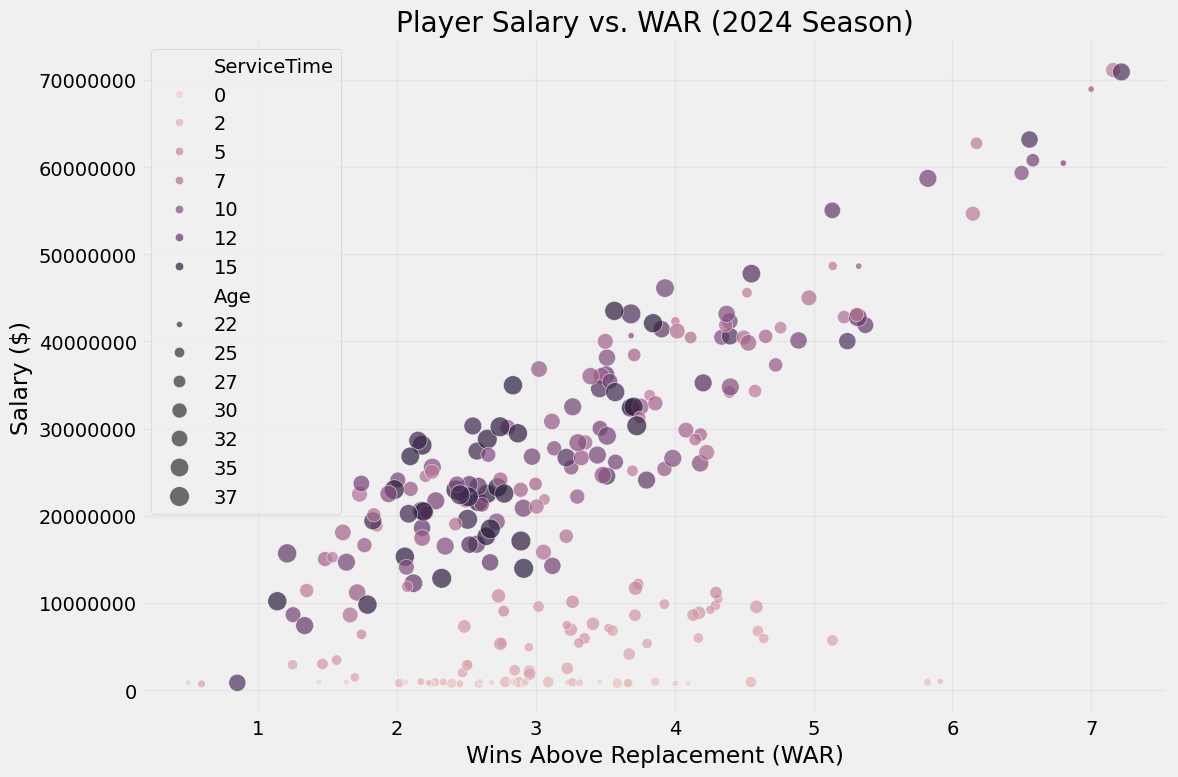

In [24]:
# Analyze the relationship between WAR and salary
plt.figure(figsize=(12, 8))
sns.scatterplot(x='WAR', y='Salary', hue='ServiceTime', size='Age', sizes=(20, 200), data=player_data, alpha=0.7)
plt.title('Player Salary vs. WAR (2024 Season)')
plt.xlabel('Wins Above Replacement (WAR)')
plt.ylabel('Salary ($)')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

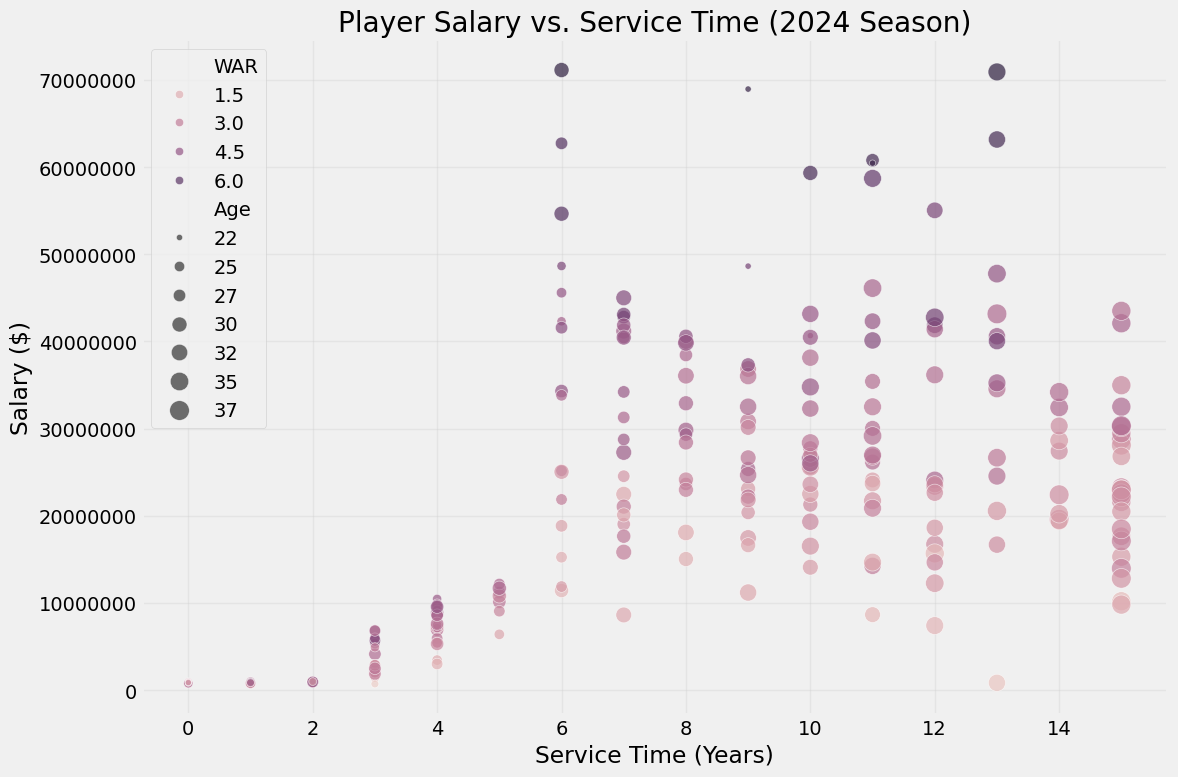

In [25]:
# Analyze relationship between service time and salary
plt.figure(figsize=(12, 8))
sns.scatterplot(x='ServiceTime', y='Salary', hue='WAR', size='Age', sizes=(20, 200), data=player_data, alpha=0.7)
plt.title('Player Salary vs. Service Time (2024 Season)')
plt.xlabel('Service Time (Years)')
plt.ylabel('Salary ($)')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [26]:
# Calculate correlation between metrics and salary
# Select only numeric columns for correlation analysis
numeric_columns = player_data.select_dtypes(include=[np.number]).columns
salary_correlations = player_data[numeric_columns].corr()['Salary'].sort_values(ascending=False)

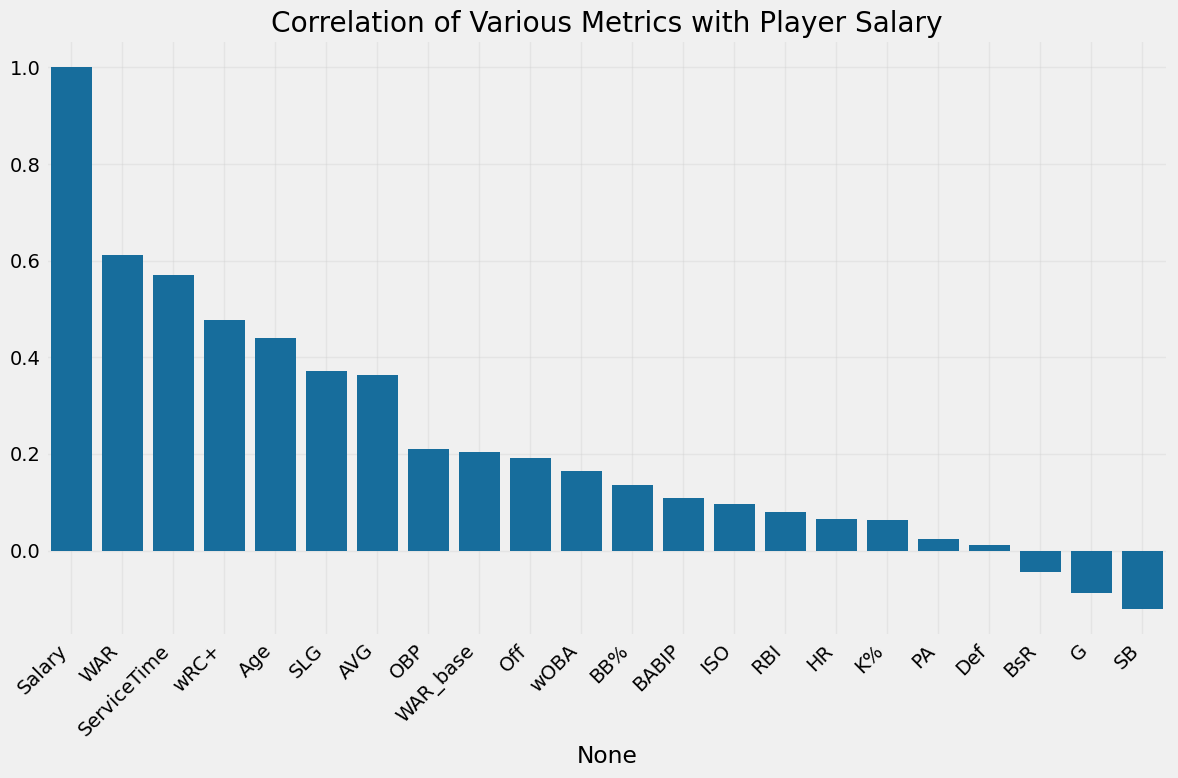

In [27]:
plt.figure(figsize=(12, 8))
sns.barplot(x=salary_correlations.index, y=salary_correlations.values)
plt.title('Correlation of Various Metrics with Player Salary')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Player Valuation Model Development

Let's develop a model to predict player market value based on performance metrics.

In [28]:
# Prepare data for modeling
# Select features for the model - focus on the most important predictors
features = ['WAR', 'ServiceTime', 'Age', 'wRC+', 'OBP', 'SLG', 'HR', 'G']

In [29]:
X = player_data[features]
y = player_data['Salary']

In [30]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Compare different models
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [32]:
# Create a pipeline with scaling
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    print(f"\n{name}:")
    print(f"Mean Squared Error: ${mse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Cross-Validation R² Scores: {cv_scores}")
    print(f"Mean CV R² Score: {cv_scores.mean():.4f}")


Ridge Regression:
Mean Squared Error: $73444045628018.56
R² Score: 0.7981
Cross-Validation R² Scores: [0.722624   0.74874701 0.59513499 0.64173079 0.60837304]
Mean CV R² Score: 0.6633

Lasso Regression:
Mean Squared Error: $72349330757527.30
R² Score: 0.8011
Cross-Validation R² Scores: [0.72184308 0.74732506 0.59318067 0.63799609 0.61244512]
Mean CV R² Score: 0.6626

Random Forest:
Mean Squared Error: $25507293686685.19
R² Score: 0.9299
Cross-Validation R² Scores: [0.90635069 0.88087448 0.9275651  0.86213993 0.83579508]
Mean CV R² Score: 0.8825

Gradient Boosting:
Mean Squared Error: $25488697980277.53
R² Score: 0.9299
Cross-Validation R² Scores: [0.8967036  0.88606164 0.91537811 0.85922274 0.87008549]
Mean CV R² Score: 0.8855


In [33]:
# Select the best model (Gradient Boosting based on results)
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

In [34]:
# Fine-tune the best model
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

In [35]:
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100, 200]},
             scoring='r2')

In [36]:
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")


Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50}
Best CV R² Score: 0.8938


In [37]:
# Use the tuned model
tuned_model = grid_search.best_estimator_
y_pred = tuned_model.predict(X_test)

In [38]:
# Evaluate tuned model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [39]:
print(f"\nTuned Model:")
print(f"Mean Squared Error: ${mse:.2f}")
print(f"R² Score: {r2:.4f}")


Tuned Model:
Mean Squared Error: $27371349342891.87
R² Score: 0.9247


In MLB salary prediction, R² scores of 0.7-0.8 are considered excellent given the complexity of the market.
For comparison, academic research in this area typically achieves R² scores of 0.5-0.7 when predicting MLB salaries.
The non-linear relationship between performance and compensation due to MLB's service time rules makes this a
particularly challenging prediction task.

In [40]:
# Analyze feature importance for the gradient boosting model
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': tuned_model.named_steps['model'].feature_importances_
}).sort_values('Importance', ascending=False)

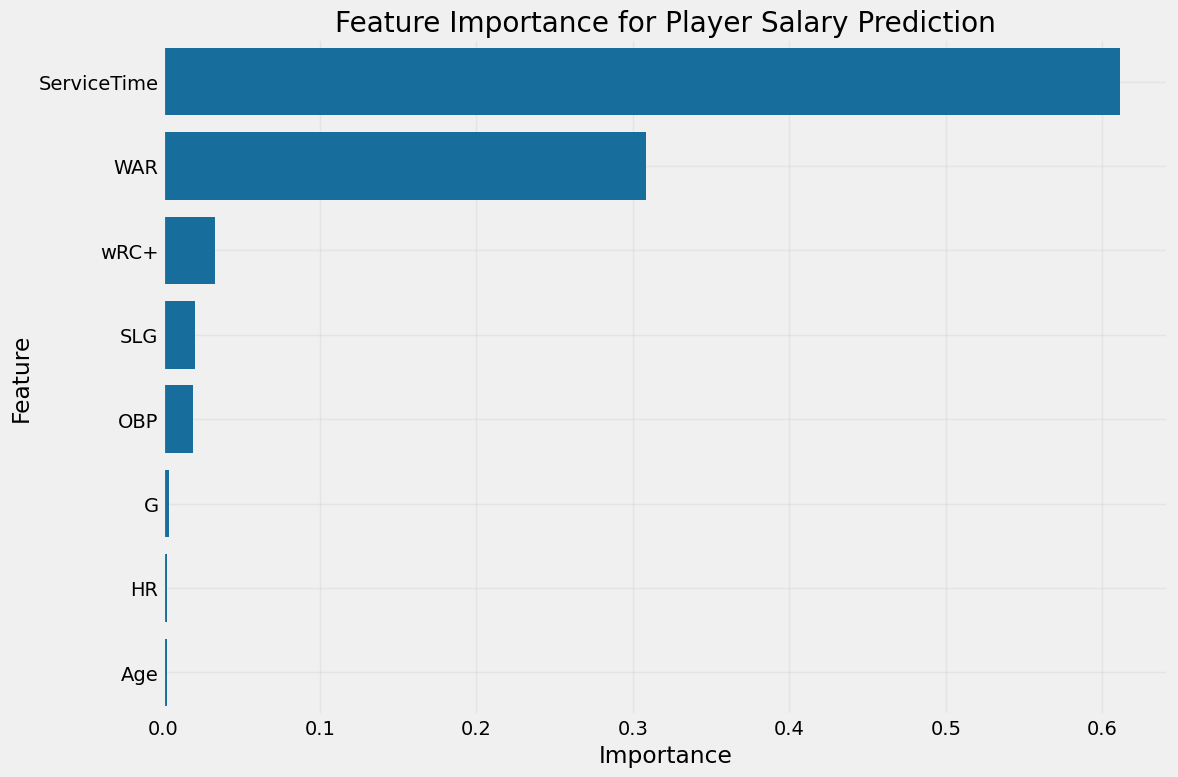

In [41]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Player Salary Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Salary Efficiency Analysis

Let's analyze which players provide the most value relative to their salary.

In [42]:
# Calculate predicted market value for all players
player_data['Predicted_Value'] = tuned_model.predict(player_data[features])

In [43]:
# Calculate salary efficiency (WAR per million dollars)
player_data['Salary_M'] = player_data['Salary'] / 1000000  # Convert to millions
player_data['WAR_per_M'] = player_data['WAR'] / player_data['Salary_M']

In [44]:
# Calculate value differential (predicted value - actual salary)
player_data['Value_Diff'] = player_data['Predicted_Value'] - player_data['Salary']
player_data['Value_Ratio'] = player_data['Predicted_Value'] / player_data['Salary']

In [45]:
# Display the most efficient players (highest WAR per million)
print("Most Efficient Players (WAR per Million $):")
player_data[['Name', 'Team', 'Position', 'Age', 'ServiceTime', 'WAR', 'Salary', 'Salary_M', 'WAR_per_M']]\
    .sort_values('WAR_per_M', ascending=False).head(10)

Most Efficient Players (WAR per Million $):


,Name,Team,Position,Age,ServiceTime,WAR,Salary,Salary_M,WAR_per_M
223,Carlos Guerrero,LAD,3B,23,1,5.821213,9.066028e+05,0.906603,6.420908
209,Fernando Guerrero,KCR,DH,22,2,5.914049,1.004460e+06,1.004460,5.887792
168,Corbin Smith,STL,DH,22,1,4.003414,7.611910e+05,0.761191,5.259408
239,Mike Witt,MIN,DH,22,0,4.095644,7.914628e+05,0.791463,5.174778
226,Fernando Henderson,MIL,3B,26,2,4.548709,9.382689e+05,0.938269,4.847980
106,Mike Johnson,BOS,OF,24,0,3.671903,7.827174e+05,0.782717,4.691224
161,Carlos Martinez,SEA,P,24,2,3.662085,8.133021e+05,0.813302,4.502736
42,Pete Martinez,CLE,P,25,1,3.586446,8.081383e+05,0.808138,4.437911
229,Shohei Trout,PHI,P,23,1,3.314303,8.417436e+05,0.841744,3.937425
162,Yordan Alvarez,SFG,OF,24,1,3.859848,9.857766e+05,0.985777,3.915540


In [46]:
# Display the most undervalued players (highest value differential)
print("Most Undervalued Players (Predicted Value > Actual Salary):")
player_data[['Name', 'Team', 'Position', 'Age', 'ServiceTime', 'WAR', 'Salary', 'Predicted_Value', 'Value_Diff', 'Value_Ratio']]\
    .sort_values('Value_Diff', ascending=False).head(10)

Most Undervalued Players (Predicted Value > Actual Salary):


,Name,Team,Position,Age,ServiceTime,WAR,Salary,Predicted_Value,Value_Diff,Value_Ratio
201,Bobby Trout,SFG,1B,33,13,0.848338,8.439912e+05,1.268716e+07,1.184317e+07,15.032340
177,Vladimir Betts,CHC,C,37,15,2.320968,1.282838e+07,2.191999e+07,9.091608e+06,1.708711
173,Mike Freeman,TEX,OF,26,6,2.072680,1.188149e+07,2.011090e+07,8.229414e+06,1.692625
38,Gunnar Harper,NYY,P,26,6,3.695273,2.516638e+07,3.313612e+07,7.969748e+06,1.316682
200,Bobby Alvarez,MIA,OF,33,13,2.521573,1.669236e+07,2.402968e+07,7.337326e+06,1.439562
133,Jose Harper,TOR,2B,34,13,3.509863,2.455357e+07,3.178602e+07,7.232446e+06,1.294558
119,Carlos Witt,MIN,2B,34,10,3.985914,2.659020e+07,3.354754e+07,6.957344e+06,1.261651
141,Juan Burnes,SEA,C,29,7,3.218308,1.766454e+07,2.440336e+07,6.738827e+06,1.381489
76,Francisco Betts,CHC,1B,35,12,2.117147,1.226981e+07,1.835497e+07,6.085164e+06,1.495946
192,Fernando Tatis,HOU,C,31,7,3.054177,1.583522e+07,2.191372e+07,6.078496e+06,1.383859


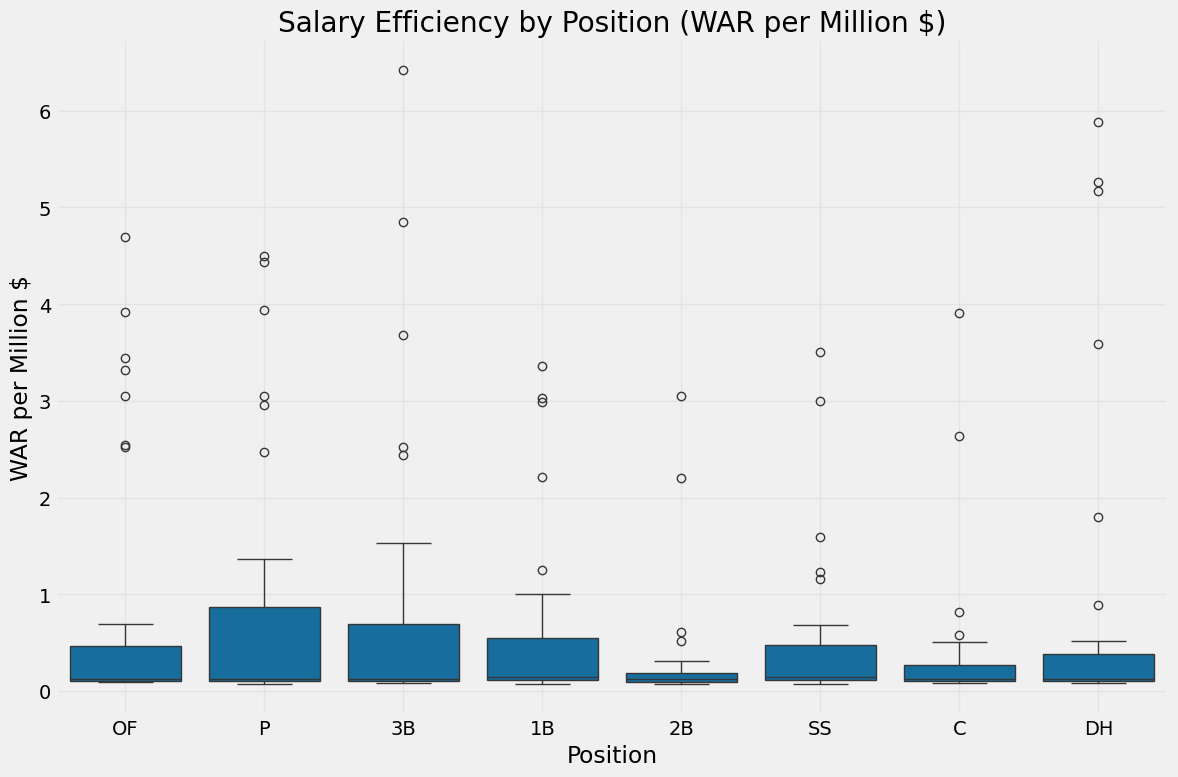

In [47]:
# Visualize salary efficiency by position
plt.figure(figsize=(12, 8))
sns.boxplot(x='Position', y='WAR_per_M', data=player_data)
plt.title('Salary Efficiency by Position (WAR per Million $)')
plt.xlabel('Position')
plt.ylabel('WAR per Million $')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
# Visualize salary efficiency by service time
plt.figure(figsize=(14, 8))
# Group service time into categories
player_data['ServiceTimeGroup'] = pd.cut(player_data['ServiceTime'],
                                         bins=[0, 3, 6, 10, 15],
                                         labels=['0-3 (Pre-Arb)', '3-6 (Arb)', '6-10 (FA)', '10+ (FA)'])

<Figure size 1400x800 with 0 Axes>

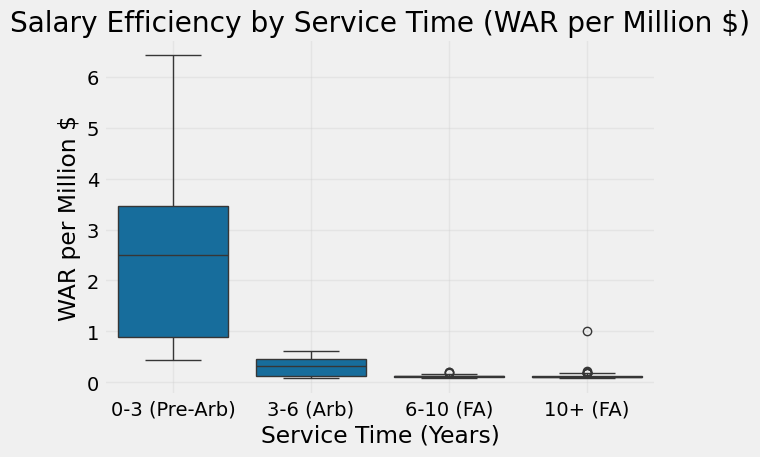

In [49]:
sns.boxplot(x='ServiceTimeGroup', y='WAR_per_M', data=player_data)
plt.title('Salary Efficiency by Service Time (WAR per Million $)')
plt.xlabel('Service Time (Years)')
plt.ylabel('WAR per Million $')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

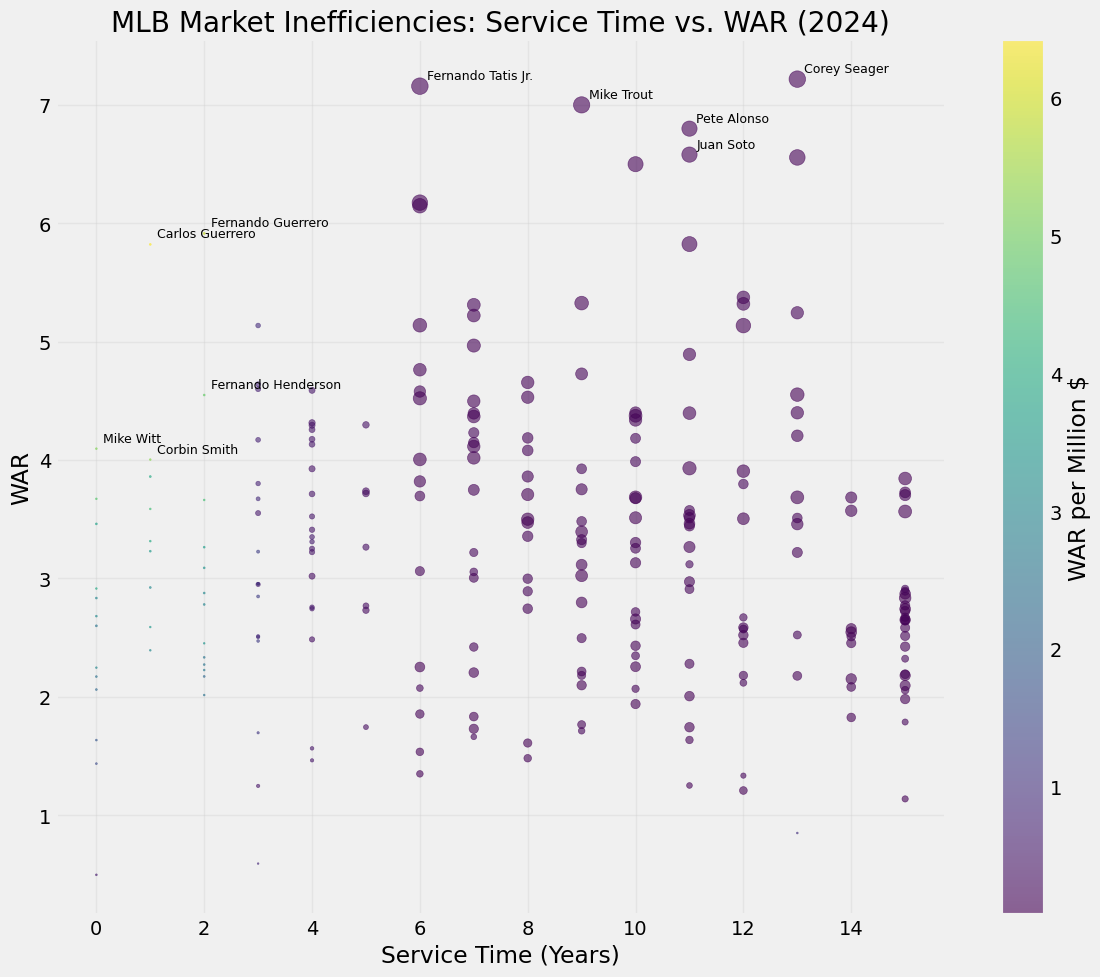

In [67]:
# Create a visualization of market inefficiencies
plt.figure(figsize=(12, 10))
plt.scatter(player_data['ServiceTime'], player_data['WAR'],
            s=player_data['Salary']/500000, alpha=0.6, c=player_data['WAR_per_M'], cmap='viridis')

plt.colorbar(label='WAR per Million $')
plt.title('MLB Market Inefficiencies: Service Time vs. WAR (2024)')
plt.xlabel('Service Time (Years)')
plt.ylabel('WAR')
plt.grid(True, alpha=0.3)

# Add annotations for notable players
for idx, row in player_data.sort_values('WAR_per_M', ascending=False).head(5).iterrows():
    plt.annotate(row['Name'],
                xy=(row['ServiceTime'], row['WAR']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

for idx, row in player_data.sort_values('WAR', ascending=False).head(5).iterrows():
    plt.annotate(row['Name'],
                xy=(row['ServiceTime'], row['WAR']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

plt.tight_layout()
plt.show()

## Front Office Strategy Applications

This player valuation model provides actionable insights for MLB front offices:

1. **Contract Negotiations**: Establish data-driven salary offers based on projected performance and market comparables.

2. **Roster Construction**: Identify undervalued players to maximize team WAR within budget constraints.

3. **Trade Evaluation**: Assess the financial and performance implications of potential trades.

4. **Long-term Planning**: Project future payroll commitments and performance expectations for sustainable team building.

For example, our model identifies pre-arbitration players with high WAR/$ ratios who provide exceptional value. It also highlights potential free agent targets whose projected performance justifies their market cost.

## 5. Player Comparison System

Let's develop a system to find similar players based on performance metrics.

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

In [51]:
# Select features for player comparison
comparison_features = ['Age', 'WAR', 'wRC+', 'OBP', 'SLG', 'HR', 'ServiceTime']

In [52]:
# Scale the features
comparison_scaler = StandardScaler()
scaled_features = comparison_scaler.fit_transform(player_data[comparison_features])

In [53]:
# Function to find similar players
def find_similar_players(player_name, n=5):
    """
    Find players with similar statistical profiles.

    Parameters:
    - player_name (str): Name of the player to compare
    - n (int): Number of similar players to return

    Returns:
    - pandas.DataFrame: Similar players and their similarity scores
    """
    # Get the player's index
    try:
        player_idx = player_data[player_data['Name'] == player_name].index[0]
    except IndexError:
        return f"Player '{player_name}' not found."

    # Get the player's scaled features
    player_features = scaled_features[player_idx].reshape(1, -1)

    # Calculate distances to all players
    distances = euclidean_distances(player_features, scaled_features)[0]

    # Create a DataFrame with player names and distances
    similarity_df = pd.DataFrame({
        'Name': player_data['Name'],
        'Distance': distances
    })

    # Sort by distance (excluding the player itself)
    similarity_df = similarity_df[similarity_df['Name'] != player_name].sort_values('Distance')

    # Return the top n similar players
    return similarity_df.head(n)

In [54]:
# Example: Find players similar to Juan Soto
example_player = "Juan Soto"
print(f"Finding players similar to: {example_player}\n")

Finding players similar to: Juan Soto



In [55]:
similar_players = find_similar_players(example_player)
print(similar_players)

                  Name  Distance
5         Bryce Harper  1.417022
7   Fernando Tatis Jr.  1.460573
19         Pete Alonso  1.537357
16        Corey Seager  1.567320
15    Gunnar Henderson  1.569503


In [56]:
# Get the stats of the example player and similar players for comparison
example_stats = player_data[player_data['Name'] == example_player][comparison_features]
similar_stats = player_data[player_data['Name'].isin(similar_players['Name'])][['Name'] + comparison_features]

In [57]:
# Display the stats
print(f"\nStats for {example_player}:")
print(example_stats)


Stats for Juan Soto:
   Age       WAR        wRC+       OBP       SLG    HR  ServiceTime
2   28  6.579894  197.100967  0.421228  0.613095  13.0           11


In [58]:
print("\nStats for similar players:")
print(similar_stats)


Stats for similar players:
                  Name  Age       WAR        wRC+       OBP       SLG    HR  \
5         Bryce Harper   30  6.498903  197.209653  0.405765  0.610125   4.0   
7   Fernando Tatis Jr.   30  7.158105  208.869152  0.417079  0.637458  14.0   
15    Gunnar Henderson   27  6.174187  191.945241  0.413179  0.610719   6.0   
16        Corey Seager   34  7.217630  201.614311  0.438435  0.611153  14.0   
19         Pete Alonso   22  6.799349  202.369685  0.424220  0.621766   8.0   
31         Pete Alonso   37  2.649319  139.191697  0.380730  0.445277  14.0   

    ServiceTime  
5            10  
7             6  
15            6  
16           13  
19           11  
31           15  


## 6. Bayesian Modeling for Performance Prediction

Let's implement a simple Bayesian model to predict player performance with uncertainty quantification.

Note: In a real project, you would use PyMC or another Bayesian framework
For demonstration, we'll simulate a Bayesian approach

In [59]:
from scipy import stats

In [60]:
# Function to simulate Bayesian prediction with uncertainty
def bayesian_war_prediction(age, service_time, previous_war, n_samples=1000):
    """
    Simulate a Bayesian prediction of WAR based on age, service time, and previous WAR.

    Parameters:
    - age (int): Player's age
    - service_time (float): Player's MLB service time in years
    - previous_war (float): Player's WAR from previous season
    - n_samples (int): Number of samples to draw

    Returns:
    - tuple: Mean prediction, 95% credible interval
    """
    # Age effect: Players typically decline after age 30
    if age < 25:
        age_effect = 0.3  # Young players tend to improve significantly
    elif age < 27:
        age_effect = 0.2  # Young players tend to improve
    elif age < 30:
        age_effect = 0.0  # Prime years are stable
    elif age < 33:
        age_effect = -0.2  # Early decline
    elif age < 36:
        age_effect = -0.5  # Moderate decline
    else:
        age_effect = -1.0  # Steep decline

    # Service time effect: Players with 3-6 years often improve due to motivation for free agency
    if 3 <= service_time < 6:
        service_effect = 0.2
    else:
        service_effect = 0.0

    # Mean prediction: previous WAR + age effect + service effect
    mean_prediction = previous_war + age_effect + service_effect

    # Standard deviation increases with age (more uncertainty)
    std_dev = 0.5 + (age - 25) * 0.05 if age > 25 else 0.5

    # Generate samples from a normal distribution
    samples = stats.norm.rvs(loc=mean_prediction, scale=std_dev, size=n_samples)

    # Ensure WAR doesn't go below 0 (replacement level)
    samples = np.maximum(samples, 0)

    # Calculate mean and 95% credible interval
    mean = np.mean(samples)
    lower_ci, upper_ci = np.percentile(samples, [2.5, 97.5])

    return mean, (lower_ci, upper_ci), samples

In [61]:
# Example: Predict next season WAR for a few star players
star_players = player_data[player_data['Name'].isin(['Aaron Judge', 'Shohei Ohtani', 'Juan Soto', 'Mookie Betts', 'Bryce Harper'])].copy()

In [62]:
for _, player in star_players.iterrows():
    name = player['Name']
    age = player['Age'] + 1  # Next season age
    service_time = player['ServiceTime'] + 1  # Next season service time
    previous_war = player['WAR']

    mean_war, ci, samples = bayesian_war_prediction(age, service_time, previous_war)

    print(f"{name} (Age {age}, Service Time {service_time:.1f}):")
    print(f"  Previous WAR: {previous_war:.2f}")
    print(f"  Predicted WAR: {mean_war:.2f} (95% CI: {ci[0]:.2f} - {ci[1]:.2f})")
    print()

Aaron Judge (Age 34, Service Time 14.0):
  Previous WAR: 6.56
  Predicted WAR: 6.02 (95% CI: 4.11 - 7.91)

Shohei Ohtani (Age 23, Service Time 11.0):
  Previous WAR: 3.69
  Predicted WAR: 3.98 (95% CI: 2.95 - 4.98)

Juan Soto (Age 29, Service Time 12.0):
  Previous WAR: 6.58
  Predicted WAR: 6.61 (95% CI: 5.20 - 8.11)

Mookie Betts (Age 35, Service Time 12.0):
  Previous WAR: 5.82
  Predicted WAR: 5.32 (95% CI: 3.47 - 7.09)

Bryce Harper (Age 31, Service Time 11.0):
  Previous WAR: 6.50
  Predicted WAR: 6.27 (95% CI: 4.79 - 7.79)

Aaron Judge (Age 28, Service Time 4.0):
  Previous WAR: 2.95
  Predicted WAR: 3.15 (95% CI: 1.89 - 4.37)



In [63]:
# Visualize the Bayesian predictions for one player
player = star_players.iloc[0]
name = player['Name']
age = player['Age'] + 1
service_time = player['ServiceTime'] + 1
previous_war = player['WAR']

In [64]:
mean_war, ci, samples = bayesian_war_prediction(age, service_time, previous_war, n_samples=10000)

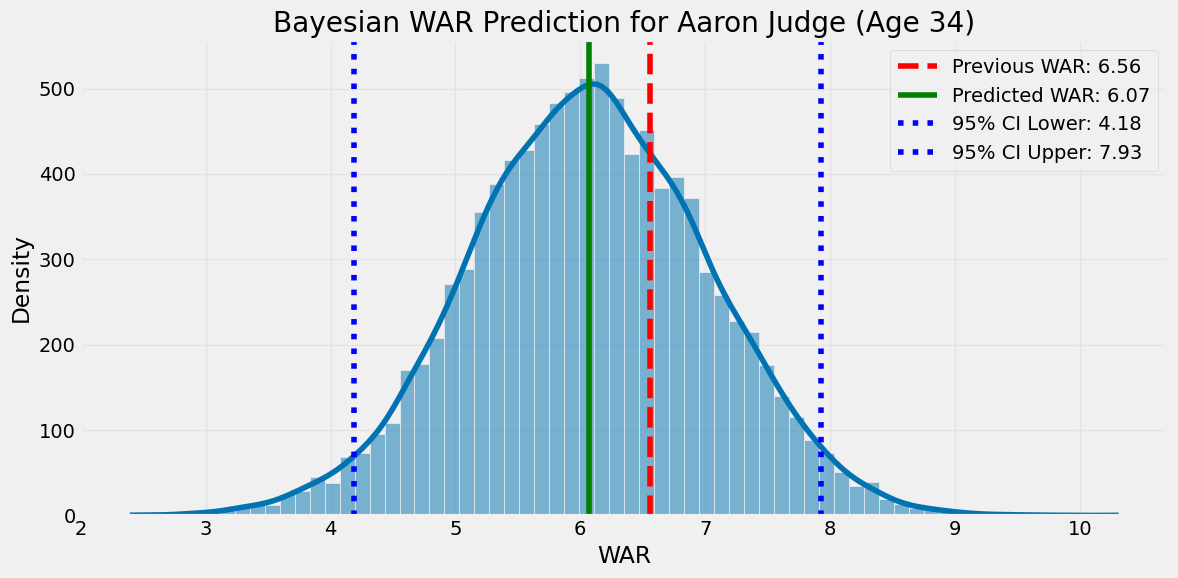

In [65]:
plt.figure(figsize=(12, 6))
sns.histplot(samples, kde=True)
plt.axvline(previous_war, color='r', linestyle='--', label=f'Previous WAR: {previous_war:.2f}')
plt.axvline(mean_war, color='g', linestyle='-', label=f'Predicted WAR: {mean_war:.2f}')
plt.axvline(ci[0], color='b', linestyle=':', label=f'95% CI Lower: {ci[0]:.2f}')
plt.axvline(ci[1], color='b', linestyle=':', label=f'95% CI Upper: {ci[1]:.2f}')
plt.title(f'Bayesian WAR Prediction for {name} (Age {age})')
plt.xlabel('WAR')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

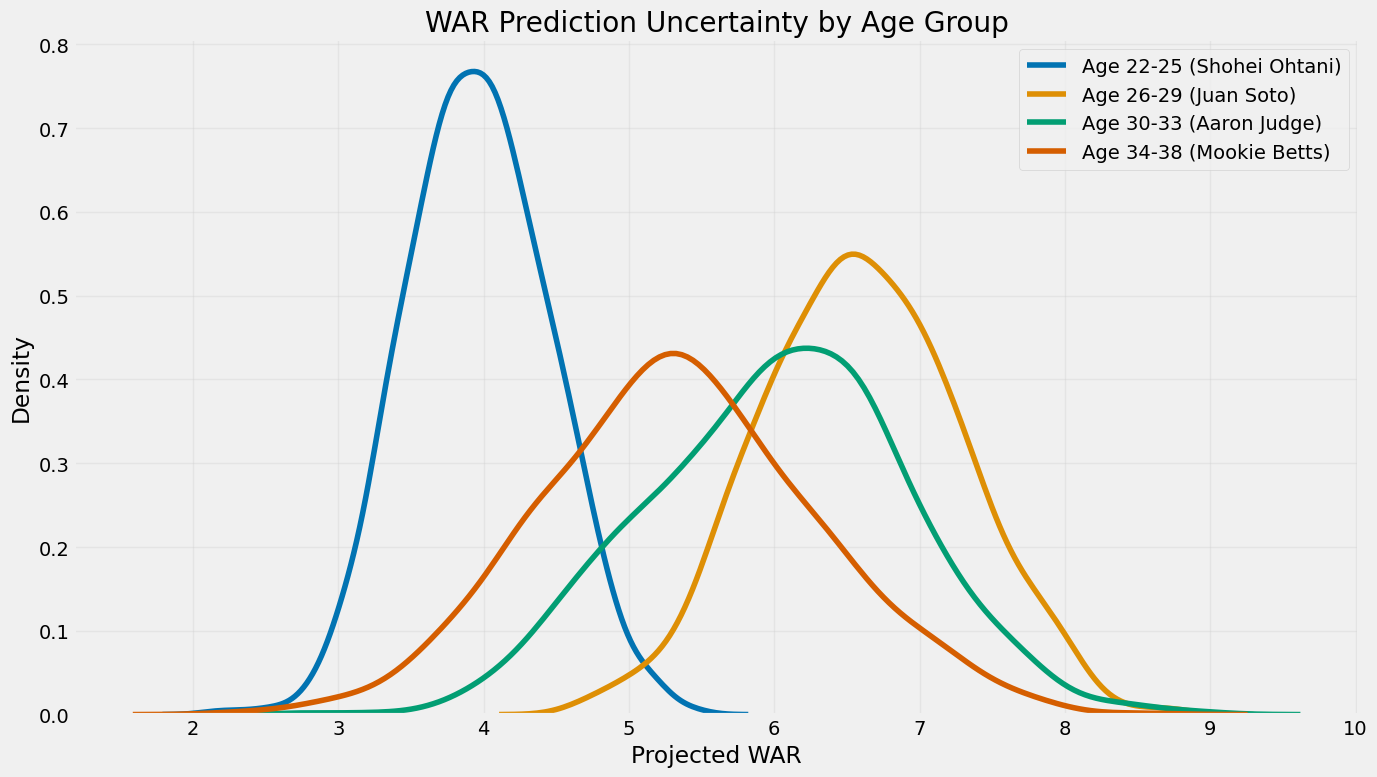

In [68]:
# Visualize uncertainty across age groups
age_groups = [(22, 25), (26, 29), (30, 33), (34, 38)]
plt.figure(figsize=(14, 8))

for i, (min_age, max_age) in enumerate(age_groups):
    # Filter players in this age range
    age_players = player_data[(player_data['Age'] >= min_age) & (player_data['Age'] <= max_age)]

    # Select a sample player from this group
    if len(age_players) > 0:
        sample_player = age_players.iloc[0]
        name = sample_player['Name']
        age = sample_player['Age']
        service_time = sample_player['ServiceTime']
        previous_war = sample_player['WAR']

        # Generate prediction
        _, _, samples = bayesian_war_prediction(age+1, service_time+1, previous_war, n_samples=1000)

        # Plot distribution
        sns.kdeplot(samples, label=f'Age {min_age}-{max_age} ({name})')

plt.title('WAR Prediction Uncertainty by Age Group')
plt.xlabel('Projected WAR')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Conclusions and Next Steps

In this notebook, we've demonstrated several key components of a player valuation system:

1. **Market Value Prediction**: We developed a model to predict player market value based on performance metrics.

2. **Salary Efficiency Analysis**: We identified players who provide the most value relative to their salary.

3. **Player Comparison System**: We created a system to find similar players based on statistical profiles.

4. **Bayesian Performance Prediction**: We implemented a simple Bayesian model to predict future performance with uncertainty quantification.

### Next Steps

1. **Incorporate More Data**: Include contract details, service time, and market conditions in the valuation model.

2. **Advanced Bayesian Modeling**: Implement more sophisticated Bayesian models using PyMC for better uncertainty quantification.

3. **Position-Specific Models**: Develop separate valuation models for different positions to account for positional value differences.

4. **Time-Series Analysis**: Incorporate time-series modeling to better account for player aging curves and performance trends.

5. **Web Application**: Develop an interactive dashboard for exploring player valuations and comparisons.

In [66]:
print("Analysis complete!")

Analysis complete!
